In [18]:
import pandas as pd

In [19]:
from shapely.geometry import Polygon

In [20]:
import numpy as np

In [21]:
from scipy.io import loadmat, savemat

In [22]:
import os

In [23]:
from PIL import Image

In [24]:
import matplotlib.patches as patches

In [25]:
from scipy.stats import mannwhitneyu

In [26]:
import matplotlib.pyplot as plt

In [27]:
from skimage import morphology
from skimage.filters import sobel
from skimage.segmentation import quickshift

In [28]:
from skimage.segmentation import find_boundaries
from skimage.segmentation import flood

In [29]:
from scipy.optimize import linear_sum_assignment

In [30]:
from sklearn.metrics import pairwise_distances

In [31]:
from sklearn.linear_model import Ridge

In [32]:
from tqdm import tqdm_notebook

In [33]:
from PIL import ImageFilter

In [34]:
CELL_SIZE = 10
SCAN_SIZE = 512

- Найти среднее всех картинок на одном уровне
- В каждой строке найти первый и последний пиксель с максимальной интенсивностью - как?

- Изменить размер изображений на 512x512
- Поменять координаты lesions

In [35]:
def sort_scans_and_plaques(files):
    if len(files) < 3:
        return []
    # IM_00023.TIF
    # IM_00032(_1).plq
    # img001.bmp
    # img012(_1).plq
    levels = {}
    for file in files:
        levels[file] = int(file[3:].split(".")[0].split("_")[0])
    min_level = min(levels.values())
    max_level = max(levels.values())
    return [(levels[file] - min_level, max_level - min_level, file) for file in files]

In [36]:
for root, dirs, files in tqdm_notebook(os.walk("../../data/Initial & repeat MRI in MS-Free Dataset/")):
    path = root.split(os.sep)
    for level, max_level, file in sort_scans_and_plaques(files):
        current_path = root + "/" + file
        _, _, _, _, patient, stage = root.split("/")
        
        full_name = file.split(".")[0]
        name_parts = full_name.split("_")
        name = "_".join(name_parts[0:2])
        additional_name = ""
        
        if len(name_parts) > 2:
            additional_name = "_" + name_parts[-1]    
        
        new_path = os.path.join("../../prepared-data", patient, stage)

        if not os.path.exists(new_path):
            os.makedirs(new_path)
        new_path += "/" + name + "-" + str(level) + '-' + str(max_level) + additional_name
        
        if (".bmp" in file) or (".TIF" in file):            
            image = Image.open(current_path)
            image = image.resize((SCAN_SIZE, SCAN_SIZE), Image.ANTIALIAS)
            image.save(new_path + ".bmp", "BMP")
        
        elif (".plq" in file):
            plq_params = loadmat(current_path)
            x_size = plq_params['x'][0][-1]
            plq_params['xi'] *= SCAN_SIZE / x_size
            plq_params['yi'] *= SCAN_SIZE / x_size
            savemat(new_path, plq_params)

- Получить усреднение изображений на каждом уровне

In [37]:
def get_z_level(file):
    name = file.split(".")[0]
    level = int(name.split("-")[-2])
    max_level = int(name.split("-")[-1])
    z_level = round(level / max_level / 4, 2) * 4
    return "{0:.2f}".format(z_level)

In [38]:
scans_by_patients = {}

for root, dirs, files in tqdm_notebook(os.walk("../../prepared-data/")):
    path = root.split(os.sep)
    for file in files:
        if (".bmp" in file):
            image = Image.open(root + "/" + file)
            _, _, _, patient, stage = root.split("/")
            patient = patient + "/" + stage
            scan = np.array(image)
            if patient not in scans_by_patients:
                scans_by_patients[patient] = {}
            scans_by_patients[patient][file] = scan

In [39]:
all_scans = {}
for patient, scans in scans_by_patients.items():
    for file, scan in scans.items():
        z_level = get_z_level(file)
        if z_level not in all_scans:
            all_scans[z_level] = []
        all_scans[z_level].append(scan)

In [40]:
assert len(all_scans) > 22

for key in sorted(all_scans.keys()):
    assert len(all_scans[key]) > 30, str(key) + " level can be insufficient"

In [41]:
mean_scans = {
    level: np.array(scans).mean(axis=0)
    for level, scans in all_scans.items()
}

In [42]:
def clean_boundaries(boundaries):
    # TODO refactor
    new_boundaries = []
    for column in boundaries.T:
        first_index = np.nonzero(column)[0]
        
        if first_index.shape[0]:
            first_index = first_index[0]
        else:
            first_index = -1
            
        last_index = np.nonzero(column[::-1])[0]
        if last_index.shape[0]:
            last_index = last_index[0]
        else:
            last_index = -1
            
        new_column = [(i == first_index) | (i == column.shape[0] - last_index) for i in range(column.shape[0])]
        new_boundaries.append(new_column)
        
    new_boundaries = np.array(new_boundaries).astype(int).T
    return new_boundaries

In [79]:
def extract_boundaries(scan):
    plt.figure(figsize=(21, 7))
    plt.subplot(151)
    plt.imshow(scan)
    plt.subplot(152)
    flooded_image = 1 - flood(scan / 255, (0, 0), tolerance=0.1)
    plt.imshow(flooded_image)
    cleaned_image = morphology.remove_small_objects(flooded_image.astype(bool), 500)
    plt.subplot(153)
    plt.imshow(cleaned_image)
    boundaries = find_boundaries(cleaned_image)
    plt.subplot(154)
    plt.imshow(boundaries)
    boundaries = clean_boundaries(boundaries)
    plt.subplot(155)
    plt.imshow(boundaries)
    plt.show()
    return np.vstack(np.nonzero(boundaries)).T

In [44]:
b = extract_boundaries(mean_scans["0.00"])

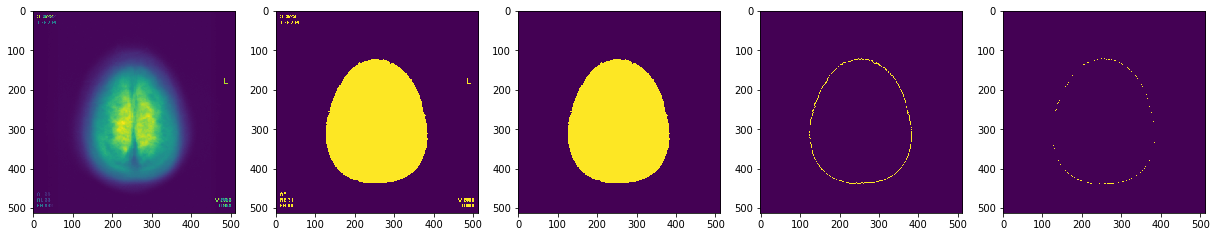

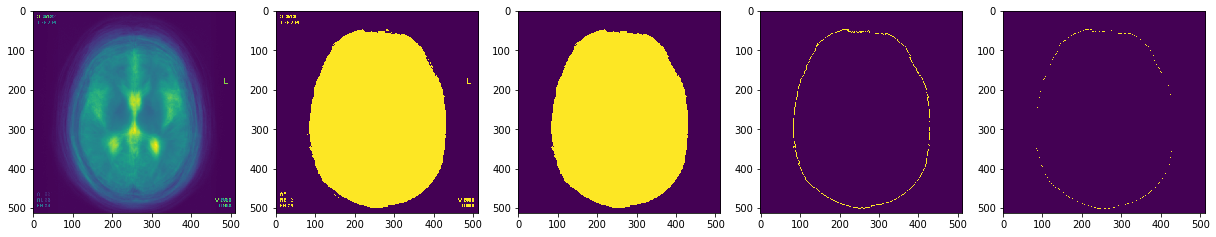

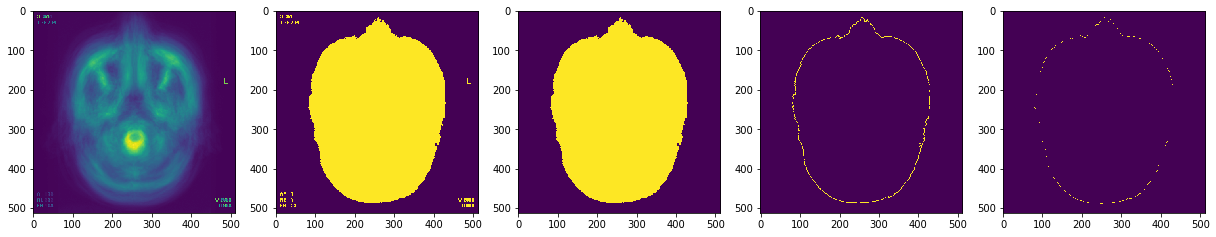

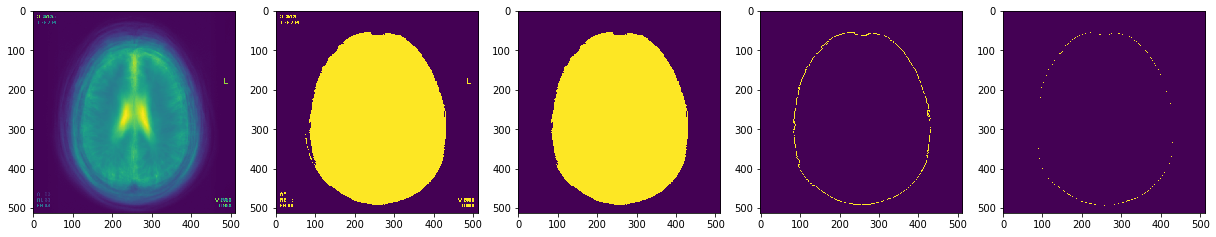

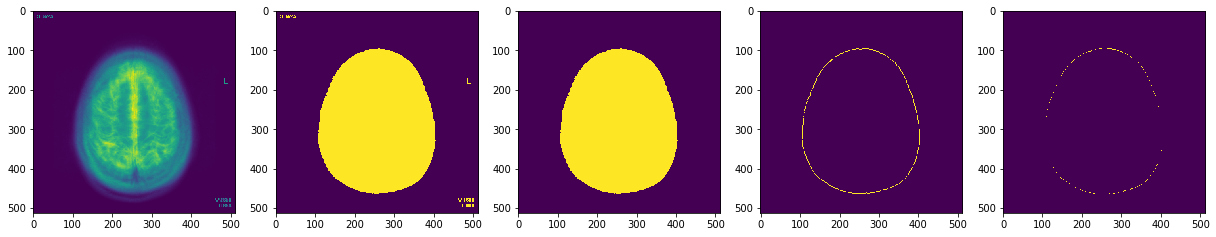

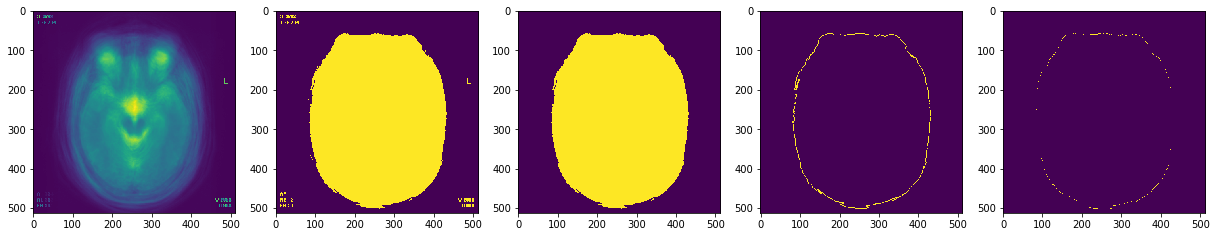

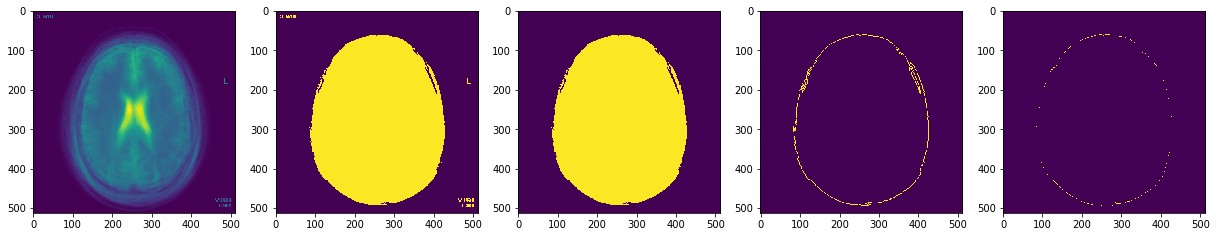

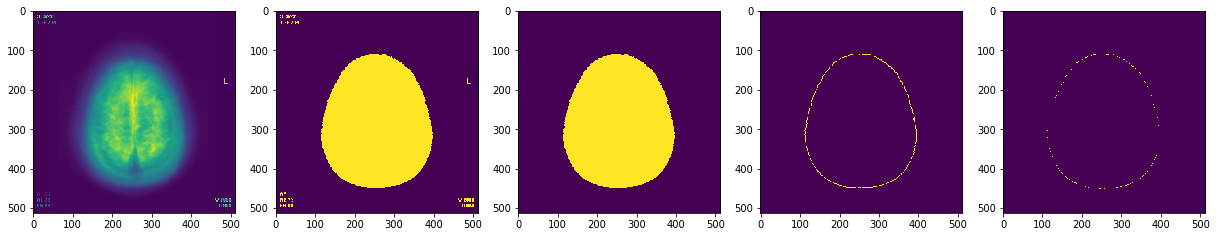

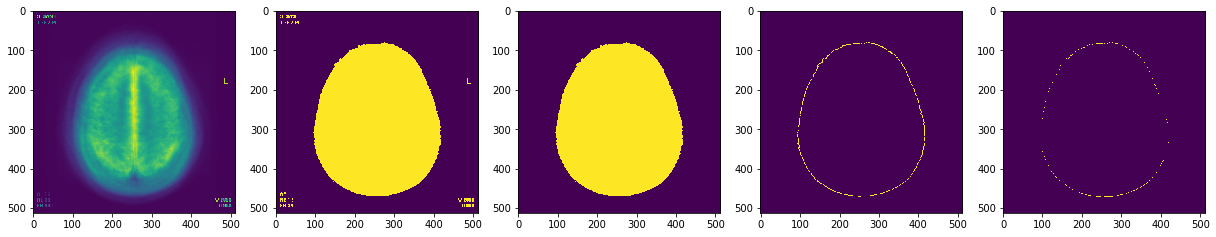

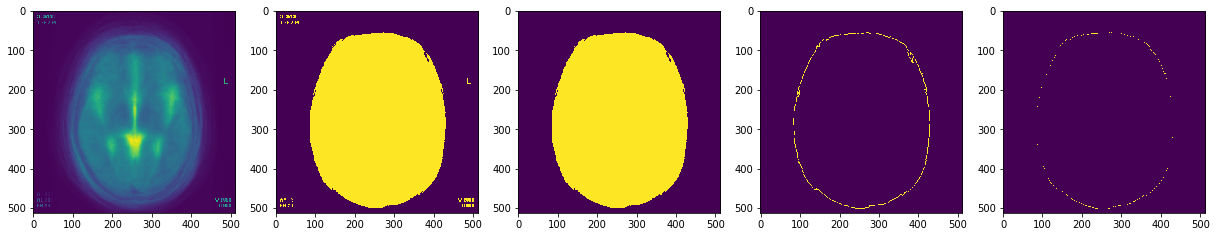

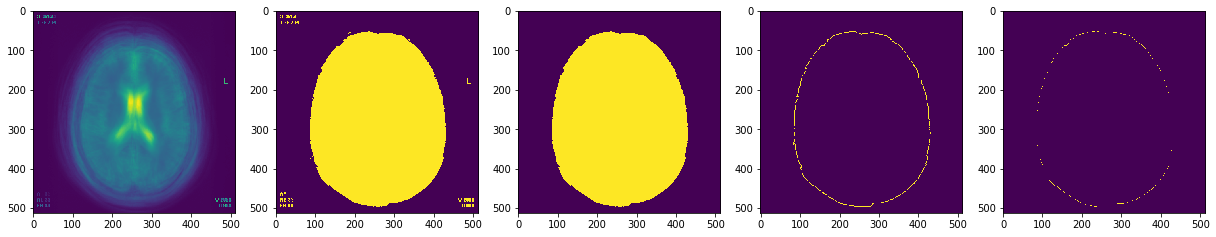

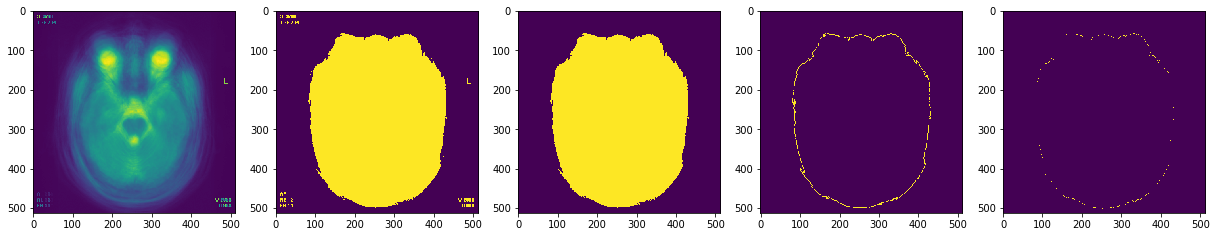

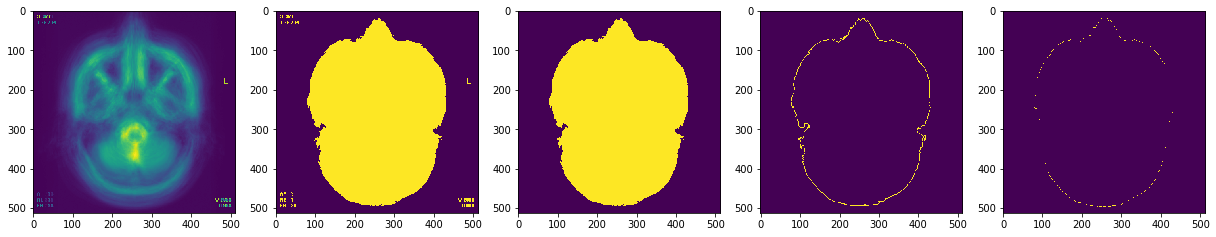

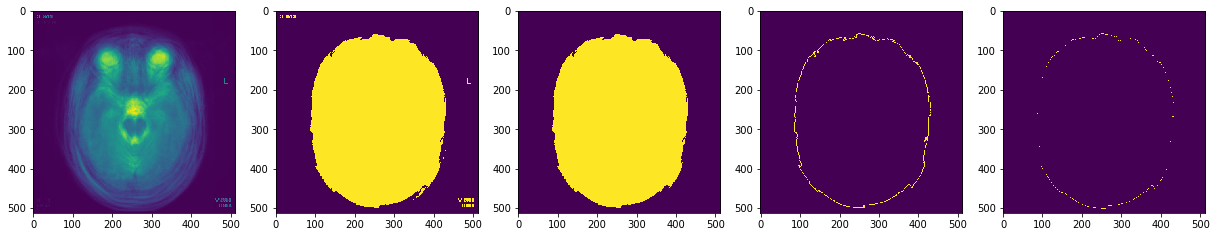

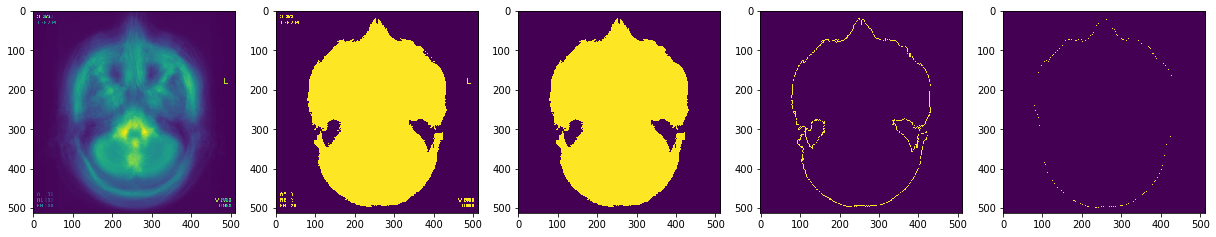

In [45]:
skull_model = {
    level: extract_boundaries(scan)
    for level, scan in mean_scans.items()
}

In [46]:
# for level in all_scans.keys():
#     for scan in all_scans[level][0:3]:
#         extract_boundaries(scan)
#         plt.show()

In [47]:
def transform_skull_slice(skull, model_boundaries):
    skull_boundaries = extract_boundaries(skull)
    random_points = np.random.choice(
        skull_boundaries.shape[0], 
        int(skull_boundaries.shape[0] * 0.3), 
        replace=False
    )
    skull_boundaries = skull_boundaries[random_points, :]
    
    all_distances = pairwise_distances(skull_boundaries, model_boundaries)
    row_ind, col_ind = linear_sum_assignment(all_distances)
    X_points = skull_boundaries[row_ind]
    Y_points = model_boundaries[col_ind]
    
    return X_points, Y_points

In [48]:
def transform_skull(skull, model):
    all_X_points = []
    all_Y_points = []
    
    for file, skull_slice in list(skull.items()):
        model_level = get_z_level(file)
        model_slice = model[model_level]
        X_points, Y_points = transform_skull_slice(skull_slice, model_slice)
        all_X_points.append(X_points)
        all_Y_points.append(Y_points)
    
    all_X_points = np.vstack(all_X_points)
    all_Y_points = np.vstack(all_Y_points)
    
    model = Ridge(alpha=0)
    model.fit(all_X_points, all_Y_points)
    W = model.coef_
    B = model.intercept_
    return W, B

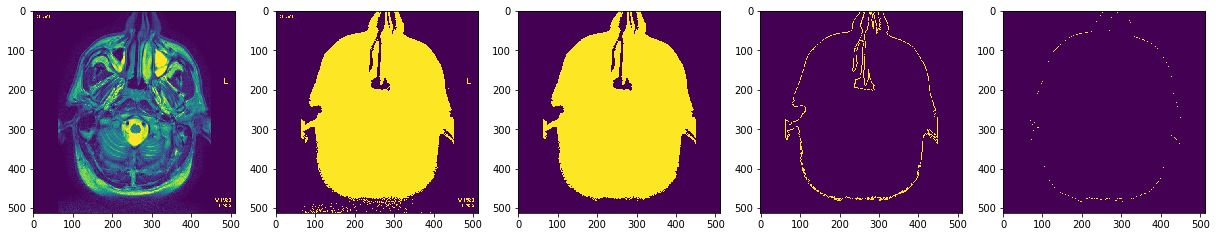

In [86]:
x_p, y_p = transform_skull_slice(all_scans["0.08"][13], skull_model["0.08"])

In [67]:
patient_scan = scans_by_patients["PRI/1"]["IM_00022-21-21.bmp"]
patient_skull = {"IM_00022-21-21.bmp": patient_scan}
x_p, y_p = transform_skull_slice(patient_scan, skull_model["1.00"])
W, B = transform_skull(patient_skull, skull_model)

In [68]:
W

array([[1.27432437, 0.02684082],
       [0.0248851 , 1.38975166]])

In [69]:
B

array([ -86.10837898, -110.61824295])

In [70]:
new_x_p = (x_p @ W + B)

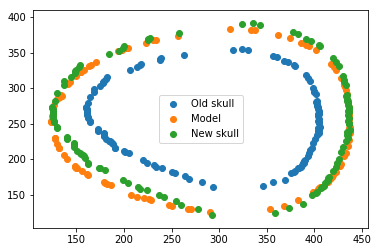

In [71]:
plt.scatter(x_p.T[0], x_p.T[1], label="Old skull")
plt.scatter(y_p.T[0], y_p.T[1], label="Model")
plt.scatter(new_x_p.T[0], new_x_p.T[1], label="New skull")
plt.legend()

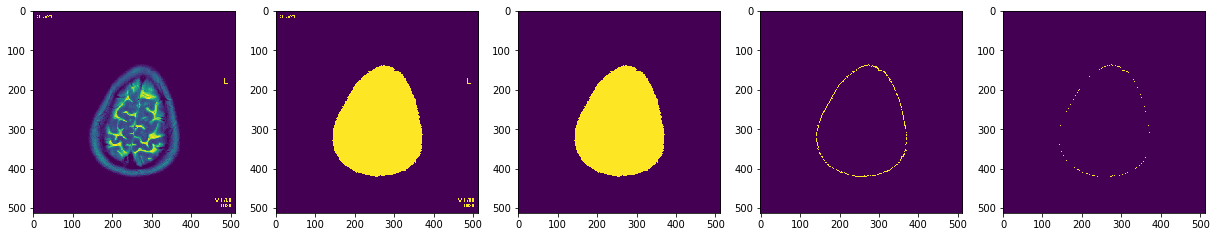

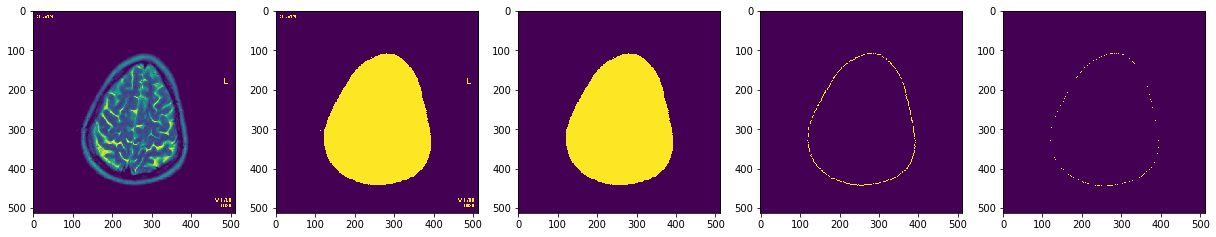

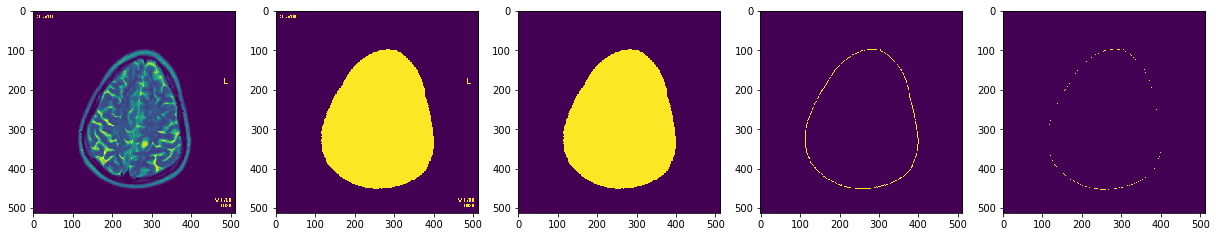

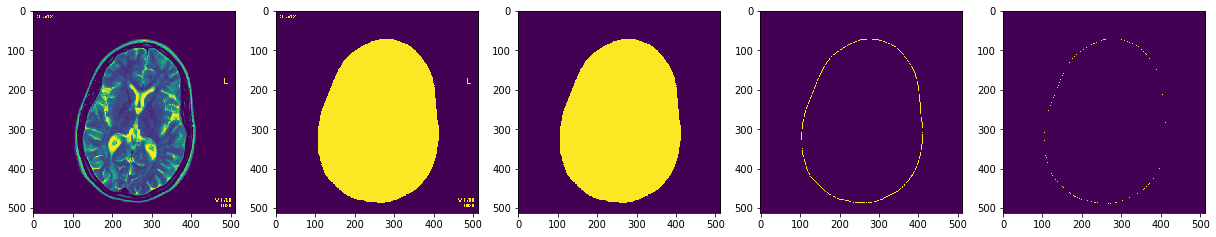

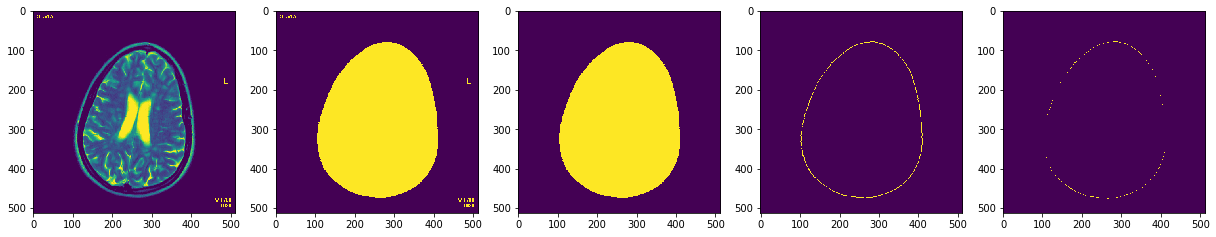

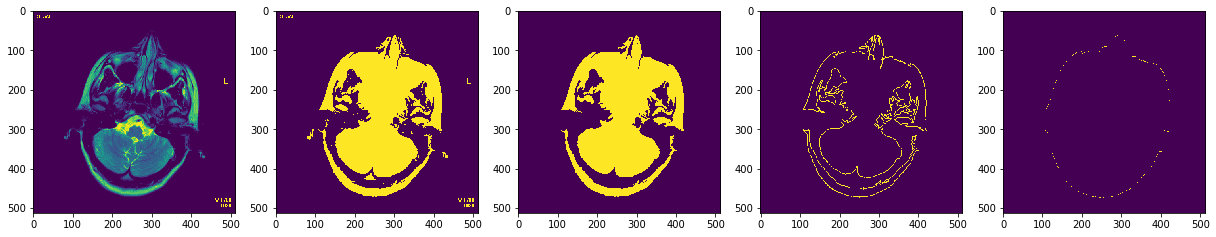

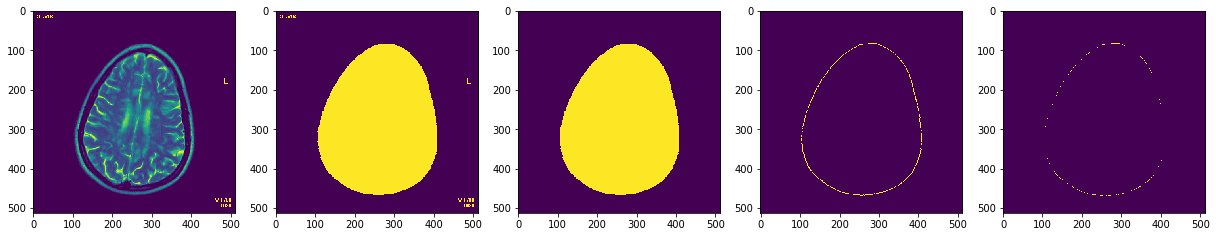

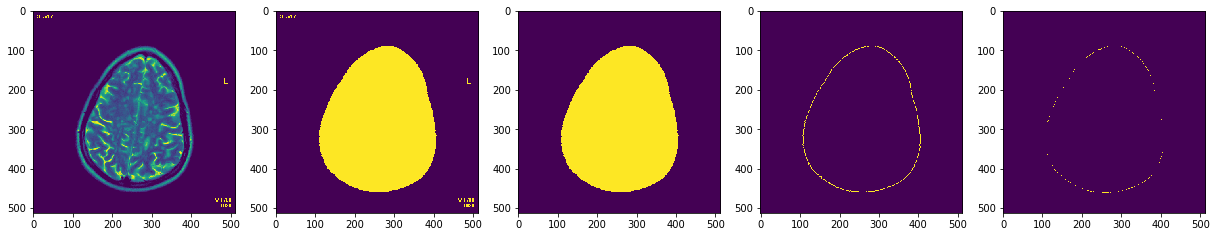

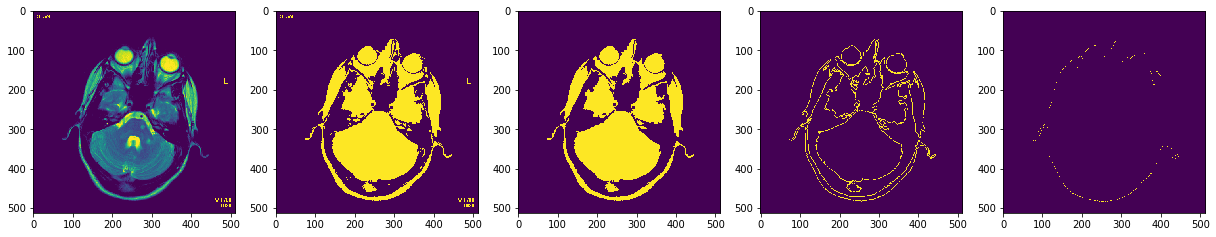

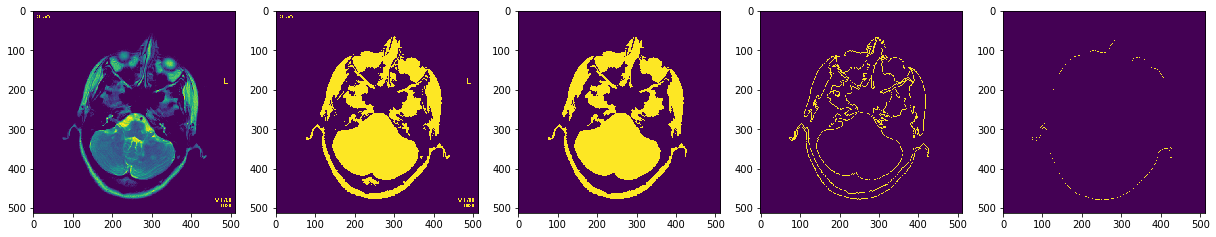

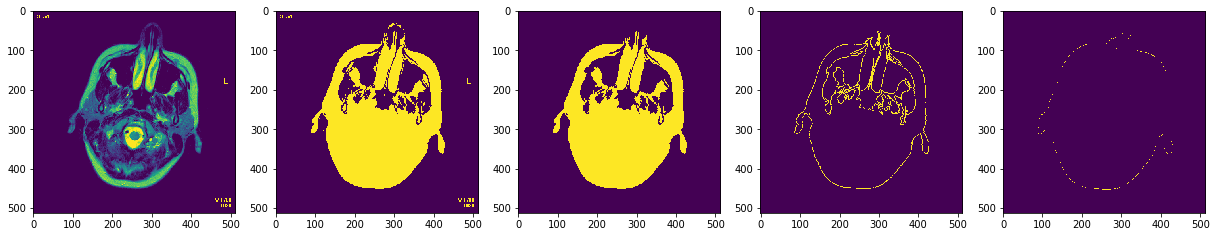

KeyboardInterrupt: 

In [65]:
skull = scans_by_patients["PRI/1"]
W, B = transform_skull(skull, skull_model)

In [72]:
# img.transform uses inversions
W = np.linalg.inv(W)
B = -B

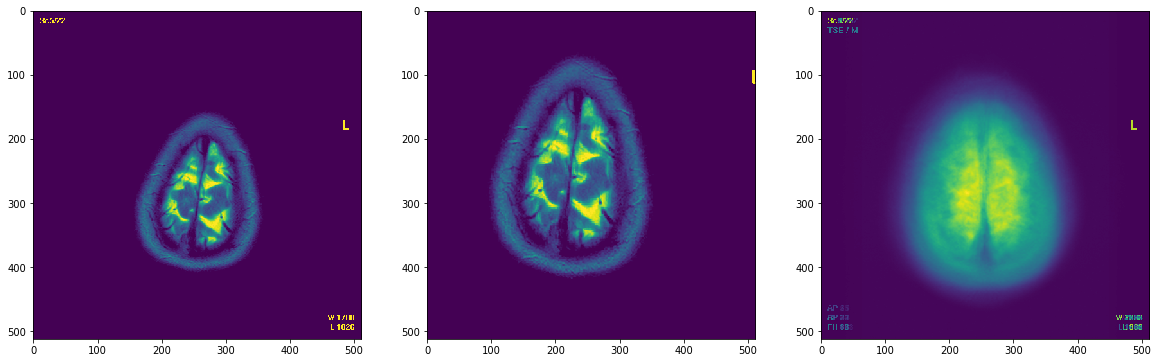

In [73]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
im = Image.open("../../prepared-data/PRI/1/IM_00022-21-21.bmp")
scan_before = np.array(im)
plt.imshow(scan_before)

plt.subplot(132)
im = im.transform(im.size, Image.AFFINE, data=[W[0, 0], W[0, 1], B[0], W[1, 0], W[1, 1], B[1]])
scan_after = np.array(im)
plt.imshow(scan_after)

plt.subplot(133)
plt.imshow(mean_scans["1.00"])

In [105]:
# transformations = {}

# for patient, skull in tqdm_notebook(scans_by_patients.items()):
#     W, B = transform_skull(skull, skull_model)
#     transformations[patient] = (W, B)

In [106]:
# plt.figure(figsize=(20, 20))
# plt.scatter(Y_points.T[0], Y_points.T[1])
# plt.scatter(X_points.T[0], X_points.T[1])
# plt.scatter((X_points @ W + B).T[0], (X_points @ W + B).T[1])

- Создать решетку и трансформировать изображение для каждого пациента

In [74]:
def plaque_iterator(path, name):
    i = 0
    plaque_name = path + name + ".mat"
    while True:
        try:
            open(plaque_name)
        except Exception as e:
            print(e)
            break
        plaque_params = loadmat(plaque_name)
        yield np.hstack([plaque_params["xi"], plaque_params["yi"]])
        i += 1
        plaque_name = "{}{}_{}.mat".format(path, name, i)

In [75]:
def intersects(i, j, plaque):
    plaque_polygon = Polygon(plaque)
    cell_polygon = Polygon([
        [i * CELL_SIZE, j * CELL_SIZE],
        [(i + 1) * CELL_SIZE, j * CELL_SIZE],
        [(i + 1) * CELL_SIZE, (j + 1) * CELL_SIZE],
        [i * CELL_SIZE, (j + 1) * CELL_SIZE]
    ])
    return plaque_polygon.intersects(cell_polygon)

In [76]:
def create_grid(path, name, W=np.eye(2, 2), B = np.zeros(2)):
    grid = np.zeros((SCAN_SIZE // CELL_SIZE, SCAN_SIZE // CELL_SIZE))
    
    # Create skull object with one slice
    # Receive W and B
    # Create
    
    for plaque in plaque_iterator(path, name):
        plaque = plaque @ W + B
        x_min = plaque.T[0].min()
        y_min = plaque.T[1].min()
        x_max = plaque.T[0].max()
        y_max = plaque.T[1].max()
        x_cell_min = int(x_min // CELL_SIZE)
        y_cell_min = int(y_min // CELL_SIZE)
        x_cell_max = int(x_max // CELL_SIZE + 1)
        y_cell_max = int(y_max // CELL_SIZE + 1)
        for i in range(x_cell_min, x_cell_max + 1):
            for j in range(y_cell_min, y_cell_max + 1):
                if intersects(i, j, plaque):
                    grid[i, j] = 1
    return grid.astype(bool)

[Errno 2] No such file or directory: '../../prepared-data/AA/1/IM_00032-9-21_4.mat'


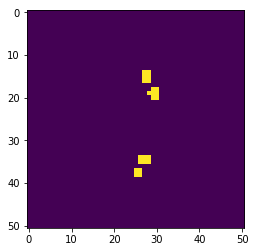

In [147]:
path = "../../prepared-data/AA/1/"
name = "IM_00032-9-21"
grid = create_grid(path, name)
plt.imshow(grid)

In [148]:
grids = {}

for patient, skull in tqdm_notebook(scans_by_patients.items()):
    for file, scan in skull.items():
        skull_part = {file: scan}
        z_level = get_z_level(file)
        path = "../../prepared-data/" + patient + "/"
        name = file.split(".")[0]
        
        W, B = transform_skull(skull_part, skull_model)
        grid = create_grid(path, name, W, B)
        
        if patient not in grids:
            grids[patient] = {}
        grids[patient][z_level] = grid

[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00012-11-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00017-16-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00016-15-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00004-3-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00011-10-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00022-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00013-12-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00020-19-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00010-9-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00019-18-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00007-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KKY/2/IM_00002-1-21.m

[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00022-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00013-12-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00020-19-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00010-9-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00019-18-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00007-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00002-1-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00014-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00015-14-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00008-7-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00006-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/PRI/1/IM_00009-8-21.mat

[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img020-19-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img012-11-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img019-18-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img017-16-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img009-8-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img014-13-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img002-1-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img023-22-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img022-21-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img024-23-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img016-15-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/KAZM/1/img027-26-26.mat'
[Errno

[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img012-11-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img005-4-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img013-12-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img008-7-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img019-18-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img022-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img002-1-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img009-8-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img010-9-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/1/img014-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/2/IM_00037-14-21_8.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/2/IM_00044-21-21.mat'
[Errno 2] No su

[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img012-11-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img019-18-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img017-16-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img009-8-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img014-13-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img002-1-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img023-22-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img022-21-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img024-23-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img016-15-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img027-26-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/2/img008-7-26.mat'
[Errno 

[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00002-1-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00014-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00015-14-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00008-7-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00006-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00009-8-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00001-0-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00021-20-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00018-17-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00003-2-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SE/2/IM_00005-4-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SKS/2/IM_00012-11-27.mat'
[Errno 2] 

[Errno 2] No such file or directory: '../../prepared-data/TE/1/img007-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img012-11-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img005-4-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img013-12-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img008-7-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img019-18-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img022-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img002-1-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img009-8-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img010-9-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TE/1/img014-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/FI/1/img011-10-21.mat'
[Errno 2] No such file or director

[Errno 2] No such file or directory: '../../prepared-data/FA/1/img025-24-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/1/img015-14-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/1/img001-0-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00037-14-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00044-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00038-15-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00036-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00024-1-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00034-11-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00026-3-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00028-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IPH/2/IM_00041-18-21.mat'
[Errn

[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img024-23-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img016-15-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img027-26-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img008-7-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img025-24-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img015-14-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/2/img001-0-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/1/IM_00037-14-21_8.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/1/IM_00044-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/1/IM_00038-15-21_5.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/1/IM_00036-13-21_5.mat'
[Errno 2] No such file or directory: '../../prepared-data/GPE/1/IM_00024-1-21.mat'
[Er

[Errno 2] No such file or directory: '../../prepared-data/KCH/2/img020-19-23.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/2/img017-16-23.mat'
[Errno 2] No such file or directory: '../../prepared-data/KCH/2/img012-11-23.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img011-10-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img013-12-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img004-3-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img003-2-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img007-6-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img010-9-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img026-25-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img005-4-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/FA/2/img006-5-26.mat'
[Errno 2] No such file or direc

[Errno 2] No such file or directory: '../../prepared-data/TE/2/img014-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img011-10-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img013-12-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img004-3-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img003-2-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img007-6-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img010-9-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img026-25-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img005-4-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img006-5-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img021-20-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/DK/2/img018-17-26.mat'
[Errno 2] No such file or director

[Errno 2] No such file or directory: '../../prepared-data/IG/1/img015-14-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img003-2-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img017-16-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img021-20-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img006-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img004-3-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img018-17-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img001-0-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img016-15-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img007-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img012-11-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/IG/1/img005-4-21.mat'
[Errno 2] No such file or director

[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00019-18-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00007-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00002-1-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00014-13-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00015-14-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00008-7-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00006-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00009-8-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00001-0-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00021-20-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00018-17-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/TZN/2/IM_00003-2-21.mat'

[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img021-20-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img018-17-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img020-19-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img012-11-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img019-18-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img017-16-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img009-8-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img014-13-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img002-1-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img023-22-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img022-21-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/TSA/1/img024-23-26.mat'
[Errno 2] No such 

[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img002-1-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img023-22-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img022-21-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img024-23-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img016-15-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img027-26-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img008-7-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img025-24-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img015-14-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/PGE/2/img001-0-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/SP/1/img011-10-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/SP/1/img020-19-21.mat'
[Errno 2] No such fil

[Errno 2] No such file or directory: '../../prepared-data/MJ/2/IM_00029-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/2/IM_00027-4-21_1.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00109-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00106-3-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00118-15-21_3.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00114-11-21_2.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00116-13-21_5.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00108-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00120-17-21_4.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00117-14-21_5.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00107-4-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/HC/1/IM_00119-16-21_1.m

[Errno 2] No such file or directory: '../../prepared-data/CK/1/img004-3-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img017-16-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img028-27-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img013-12-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img006-5-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img010-9-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img018-17-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img011-10-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img027-26-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img005-4-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img003-2-27.mat'
[Errno 2] No such file or directory: '../../prepared-data/CK/1/img024-23-27.mat'
[Errno 2] No such file or directo

[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img021-20-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img018-17-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img020-19-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img012-11-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img019-18-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img017-16-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img009-8-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img014-13-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img002-1-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img023-22-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img022-21-26.mat'
[Errno 2] No such file or directory: '../../prepared-data/CHEM/1/img024-23-26.mat'
[Errno

[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00081-6-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00096-21-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00085-10-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00095-20-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00082-7-21_1.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00080-5-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00086-11-21_5.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00090-15-21_11.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00094-19-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00077-2-21.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00089-14-21_7.mat'
[Errno 2] No such file or directory: '../../prepared-data/MJ/1/IM_00087-12-21_5.ma

# Statistical test for the location

In [149]:
edss_df = pd.read_excel("../../data/PatientCodes-Names-full.xls")

In [150]:
edss_df = edss_df.drop([0]).reset_index(drop=True)

In [151]:
edss_df["EDSS"] = edss_df["EDSS-5(2010)"]

In [152]:
edss_df["class"] = edss_df["EDSS"] > 2

In [153]:
healthy_group = edss_df[~edss_df["class"]]["CODE"].tolist()
ms_group = edss_df[edss_df["class"]]["CODE"].tolist()

In [154]:
# def reduce_grid(grid, min_z_shape):
#     grid = grid.copy()
#     z_shape = grid.shape[0]
    
#     while z_shape > min_z_shape:
#         z_slice = np.random.randint(0, z_shape - 1)
#         grid[z_slice] = (grid[z_slice] | grid[z_slice + 1])
#         grid = np.vstack([grid[:z_slice], grid[z_slice + 1:]])
#         z_shape = grid.shape[0]
        
#     return grid

In [155]:
first_grid = grids["AA/1"]["0.00"]
x_shape = first_grid.shape[0]
y_shape = first_grid.shape[1]

In [156]:
z_shape = len(skull_model)

In [157]:
significance = np.ones((z_shape, x_shape, y_shape))
means = np.zeros((z_shape, x_shape, y_shape))

for i_k, k in enumerate(sorted(skull_model.keys())):
    for i in range(0, x_shape):
        for j in range(0, y_shape):
            first_sample = [g[k][i, j] for p, g in grids.items() if (p.split("/")[0] in healthy_group) and (k in g)]
            second_sample = [g[k][i, j] for p, g in grids.items() if (p.split("/")[0] in ms_group) and (k in g)]
            if np.sum(first_sample) + np.sum(second_sample):
                significance[i_k, i, j] = mannwhitneyu(first_sample, second_sample).pvalue
                means[i_k, i, j] = np.mean(second_sample)

In [158]:
significance.min()

0.017464994593442543

In [159]:
test_path = "../../data/Initial & repeat MRI in MS-Free Dataset/AA/1/"

In [160]:
threshold = 0.05

In [161]:
patient_scans = scans_by_patients["AA/1"]

https://www.imaios.com/en/e-Anatomy/Head-and-Neck/Brain-MRI-in-axial-slices

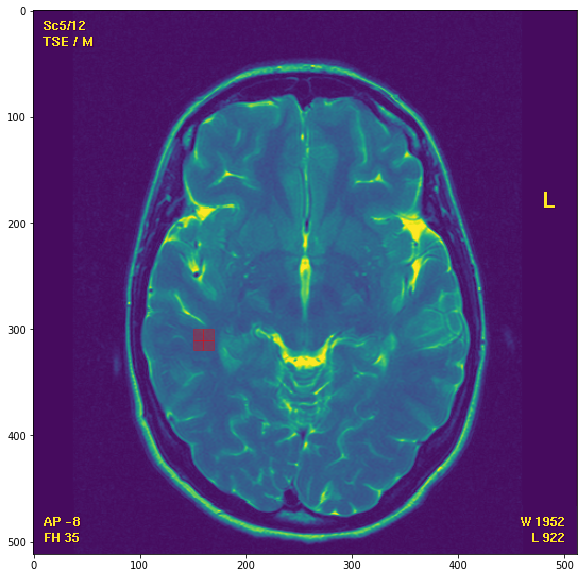

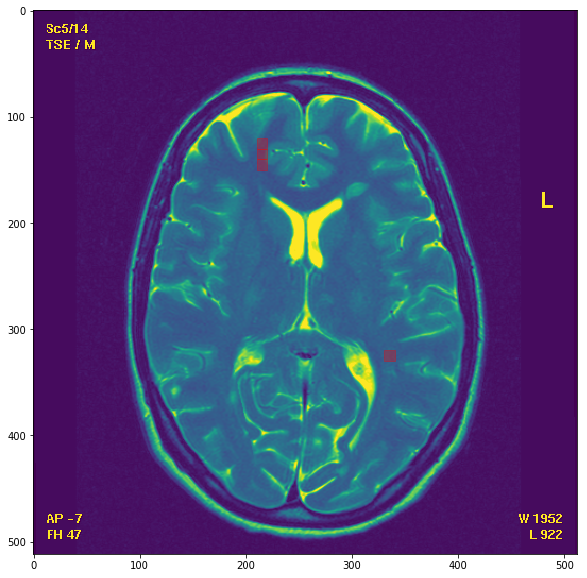

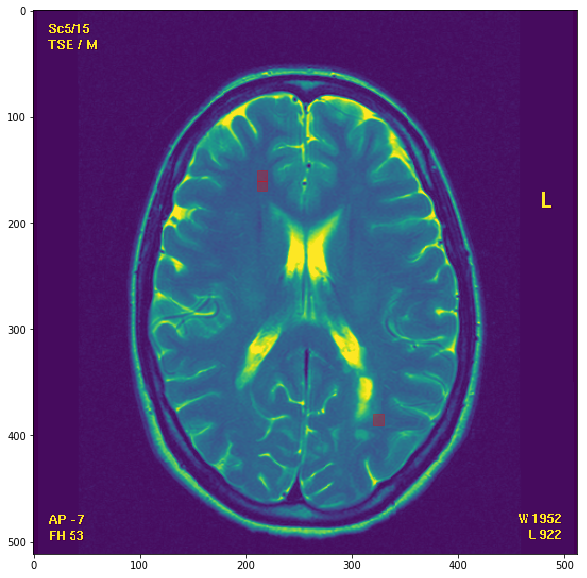

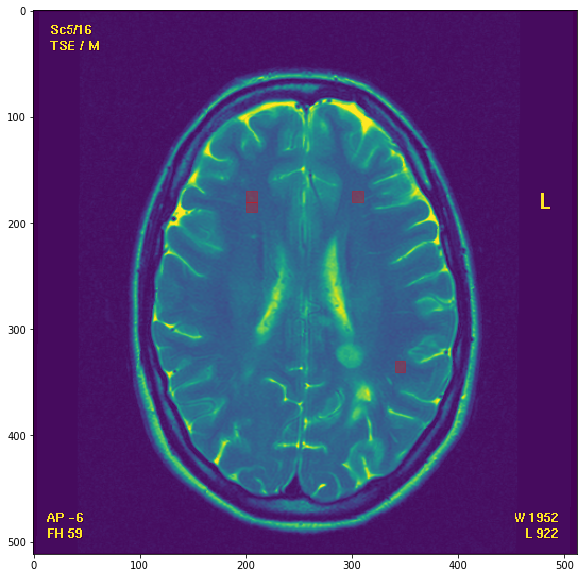

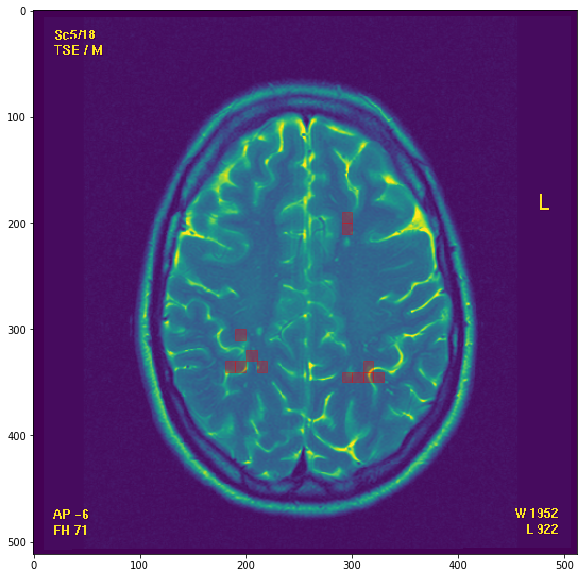

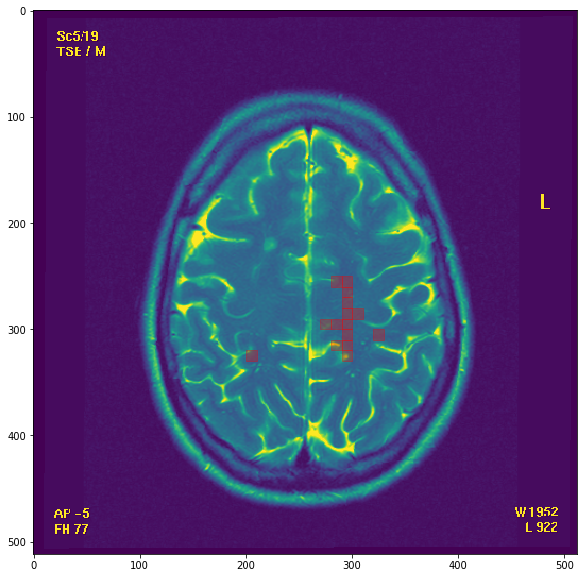

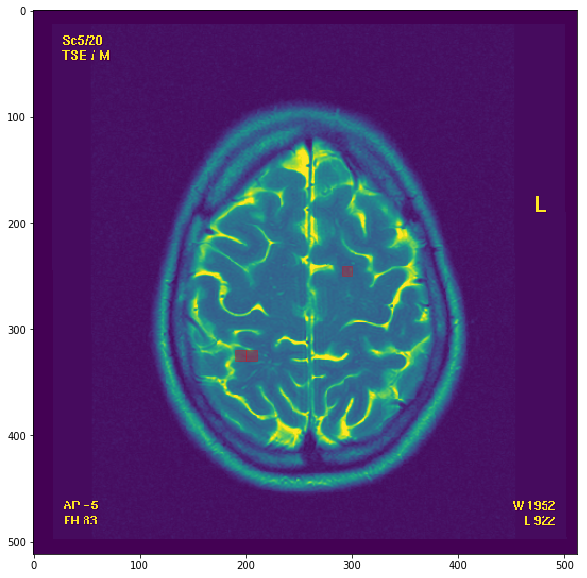

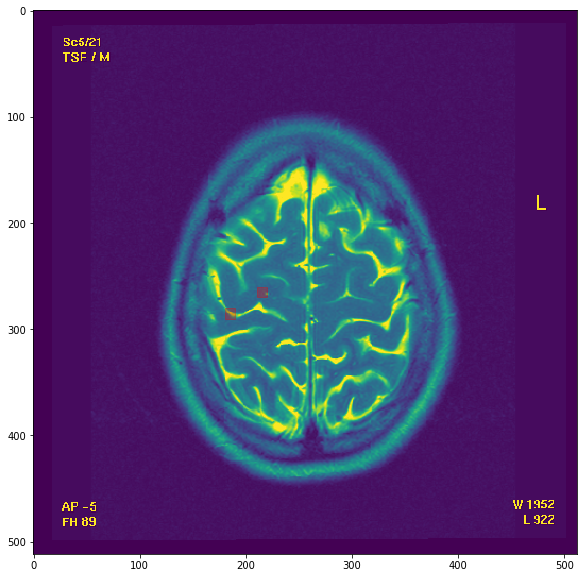

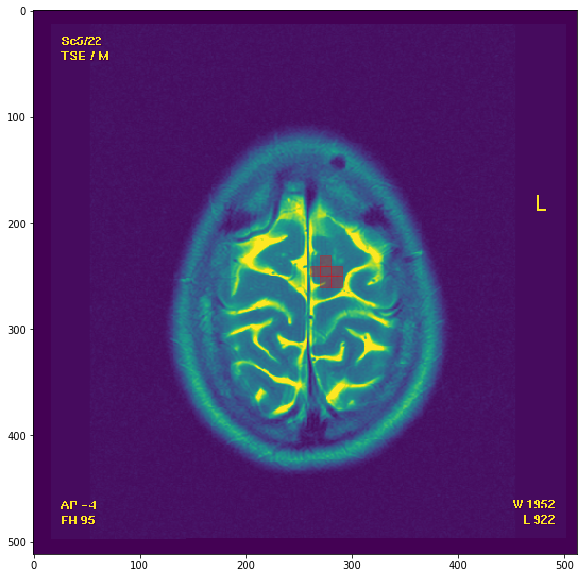

In [162]:
test_path = "../../prepared-data/AA/1"
patient_scans = scans_by_patients["AA/1"]

for slice_index, filename in enumerate(sorted(patient_scans.keys())):
    if significance[slice_index].min() > threshold:
        continue
        
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    image = Image.open(test_path + "/" + filename)    
    skull = {filename: np.array(image)}
    W, B = transform_skull(skull, skull_model)
    W = np.linalg.inv(W)
    B = -B
    image = image.transform(
        image.size, 
        Image.AFFINE, 
        data=[
            W[0, 0], W[0, 1], B[0], 
            W[1, 0], W[1, 1], B[1]
        ]
    )
    plt.imshow(np.array(image))
    
    for i in range(0, x_shape):
        for j in range(0, y_shape):
            if significance[slice_index, i, j] < threshold:
                rect = patches.Rectangle((i * CELL_SIZE, j * CELL_SIZE), CELL_SIZE, CELL_SIZE, color="red", alpha=0.3)
                ax.add_patch(rect)
    plt.show()

Report:
- Presented distortions
- Transforming algorithm
- Significant regions